In [23]:
import sys
sys.path.append('../code')

from SamplingWalk import *
from tsp import *
import dynamiqs as dq
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

# Problem: Travelling Salesperson Problem (TSP)

Given a list of $n$ cities with specific distance between each of them, what finding the shortest route that visits every city exactly once. The problem is represented with a graph whose vertices and edges respectively correspond to the cities and path between them. The distance between each pair of cities is given by the weight of their connecting edge. The original QUBO encoding uses $n^2$ qubits ([Lucas, 2014](https://www.frontiersin.org/journals/physics/articles/10.3389/fphy.2014.00005/full)). However, one can obtain a more efficient encoding with $n\lceil\log_2(n)\rceil$ qubits at the cost of expressing TSP as a HUBO ([Glos et al., 2022](https://www.nature.com/articles/s41534-022-00546-y)). In this higher-order encoding, each city is encoded in binary with $\lceil\log_2(n)\rceil$ bits. Thus, one needs $n$ of these sequences to list all cities. Therefore, each assignment $x$ has two labels, $x_i$ is the $i$-th bitstring sequence and $x_{i,j}$ is the $j$-th bit of sequence $x_i$. The cost function of the HUBO encoding of TSP reads ([Glos et al., 2022](https://www.nature.com/articles/s41534-022-00546-y)):
$$C(x)=\lambda\sum_{i=0}^{n-1}C_{1}(x_i)+\gamma\sum_{i=0}^{n-1}\sum_{j=i+1}^{n-1} C_{2}(x_i,x_j) \\ +\mu\sum_{i,j=0, i\neq j}^{n-1}w_{ij}\sum_{k=0}^{n-1}C_{2}(x_k,i)C_{2}(x_{k+1},j),$$

where $w_{ij}$ is the weight of edge $(i,j)$ and $\lambda,\gamma>\mu \max_{(i,j)}w_{ij}$. The subcost $C_1$ puts a penalty if a sequence encodes an invalid city, i.e. if its input if greater than $n-1$. Let $n-1=\tilde{x}_{\lceil\log_2(n)\rceil-1}\cdots \tilde{x}_0=\tilde{x}$ and $S$ be the set of indices of $\tilde{x}$ equal to zero, i.e. $S=\{j \mid\tilde{x}_j=0\}$. Hence, the first penalty reads ([Glos et al., 2022](https://www.nature.com/articles/s41534-022-00546-y)):
$$C_1(x_i)=\sum_{j\in S}x_{i,j}\prod_{k=j+1}^{\lceil\log_2(n)\rceil-1}\left(1-(x_{i,k}-\tilde{x}_k)^2\right).$$
The second subcost $C_2$ is used to verify if two sequences $x$ and $y$ encode the same city ([Glos et al., 2022](https://www.nature.com/articles/s41534-022-00546-y)):
$$C_2(x,y)=\prod_{k=0}^{\lceil\log_2(n)\rceil-1}\left(1-(x_k-y_k)^2\right).$$

Let us give a simple example of the encoding. Given a map of 4 cities labelled from 0 to 3, the path <span style="color:red">1</span> -> <span style="color:cyan">3</span> -> <span style="color:lime">0</span> -> <span style="color:orange">2</span> is encoded with 8 bits as
$x=$<span style="color:red">01</span><span style="color:cyan">11</span><span style="color:lime">00</span><span style="color:orange">10</span>.


## Problem generation

We generate an instance of TSP.

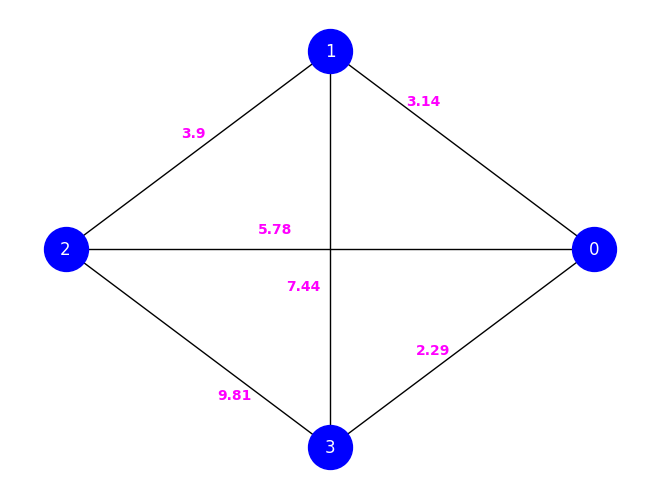

In [36]:
# Number of cities (size of the graph)
n_cities = 4

# Number of qubits
n = int(n_cities * np.ceil(np.log2(n_cities)))

# Generation of the map (graph whose vertices are cities and edges path between them)
g = nx.complete_graph(n_cities)

# Get weighted adjacency matrix
for (u, v) in g.edges():
    g[u][v]['weight'] = np.random.uniform(low=1., high=10.)
adj_matrix = nx.to_numpy_array(g, weight='weight')

# Values of coefficients for the cost function
mu = 1.0
# Compute max weight for i ≠ j
max_weight = np.max(adj_matrix[~np.eye(adj_matrix.shape[0], dtype=bool)])  # exclude diagonal
# Choose lam and gamma slightly larger than B * max_weight
lam = 2 * mu * max_weight
gamma = 2 * mu * max_weight

# Display
pos = nx.circular_layout(g)
node_size = 1000
nx.draw(
    g, pos,
    with_labels=True,
    node_color='blue',
    edge_color='black',
    node_size=node_size,
    font_color='white'
)

# Draw edge labels at random positions along each edge
for (u, v) in g.edges():
    w = round(g[u][v]['weight'],2)
    t = np.random.uniform(0.3, 0.7)  # position along the edge (avoid nodes)
    # linear interpolation for position
    x = pos[u][0] * (1 - t) + pos[v][0] * t
    y = pos[u][1] * (1 - t) + pos[v][1] * t
    # optional small perpendicular offset
    dx = pos[v][1] - pos[u][1]
    dy = pos[u][0] - pos[v][0]
    scale = 0.05  # adjust offset
    x += scale * dx
    y += scale * dy
    plt.text(x, y, str(w), color='magenta', ha='center', va='center', fontweight='bold')

plt.show()

We first use a brute-force approach to compute the solutions of the problem to compare with the results obtained with SamBa GQW.

In [37]:
# Compute cost for all bitstrings
cost_values = []
for i in range(2**n):
    bitstr = int_to_bitstring(i,n)         # convert integer to binary vector
    cost_val = cost_tsp(bitstr,adj_matrix,lam,gamma,mu)
    cost_values.append(cost_val)

# Normalize to [0,1] (1 = minimum cost, 0 = maximum cost)
cost_values = np.array(cost_values)
min_val = cost_values.min()
max_val = cost_values.max()
normalized_values = 1 - (cost_values - min_val) / (max_val - min_val)

# Create the dictionary: each key is a computational basis state (integer version) and the value is its quality (1 for optimal solutions, 0 for worst)
cost_quality_dict = {i: normalized_values[i] for i in range(2**n)}

We visualize the cost function on the solution space ($n$-dimensional hypercube) where the color of the vertices depends on their quality, which is 1 for optimal solutions and 0 for worst.

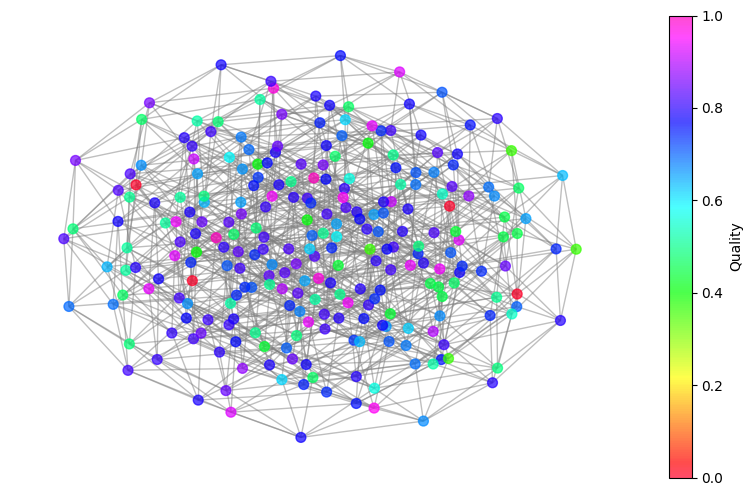

In [38]:
# Solution graph (each node of this hypercube corresponds to a computational basis state, i.e. a decision)
mixer_graph = nx.hypercube_graph(n) # hypercube since we use X-mixer for this problem

# Map vertex -> value
node_colors = [cost_quality_dict[int("".join(map(str, node)), 2)] for node in mixer_graph.nodes()]

cmap = plt.cm.gist_rainbow

# Create figure + axes explicitly
fig, ax = plt.subplots(figsize=(10, 6))

# Layout (spring or shell works well)
pos = nx.spring_layout(mixer_graph, seed=42)

# Draw graph
nodes = nx.draw_networkx_nodes(
    mixer_graph, pos, node_color=node_colors, cmap=cmap,
    vmin=0, vmax=1, node_size=50, ax=ax, alpha=0.7
)

nx.draw_networkx_edges(
    mixer_graph, pos,
    edge_color="gray",   # set all edges to gray
    alpha=0.5,
    ax=ax
)

# Add colorbar linked to nodes
cbar = fig.colorbar(nodes, ax=ax)
cbar.set_label("Quality")

ax.axis("off")
plt.show()

## SamBa GQW: classical part

We create an instance of SamBa-GQW for MaxCut with $X$-mixer, then we perform the sampling protocol and compute the mean of the sampled energy gaps.

In [39]:
# Creation of instance of SamBa GQW

use_qutip = False # QuTip or Dynamiqs

if use_qutip:
    mixer = nx.adjacency_matrix(nx.hypercube_graph(n)).todense() # dense representation
else:
    mixer = dq.sparsedia_from_dict(hypercube_adjacency_sparse_final(n)) # sparse representation

samba_gqw = SamplingWalk(n,
                      cost=cost_tsp, # MaxCut cost function
                      mixer=mixer, # Mixer (here n-dimensional hypercube)
                      use_qutip=True, # We use Dynamiqs
                      use_density_matrix=False, # State vector representation
                      convert_input_cost_fun=int_to_bitstring, # Function to convert integer to binary vectors
                      cost_kwargs={'adj_matrix':adj_matrix, 'lam':lam, 'gamma':gamma, 'mu':mu} # Additional inputs of the cost function
            )

# Sampling protocol
q = n**2 # Quadratic sampling
neighbors_fun = hamming_neighbors # X-mixer (hypercube) neighboring function
samba_gqw.sampling_protocol(q=q, neighbors_fun=neighbors_fun)
samba_gqw.compute_mean_gaps()

We visualize the vertices (states) sampled on the solution graph.

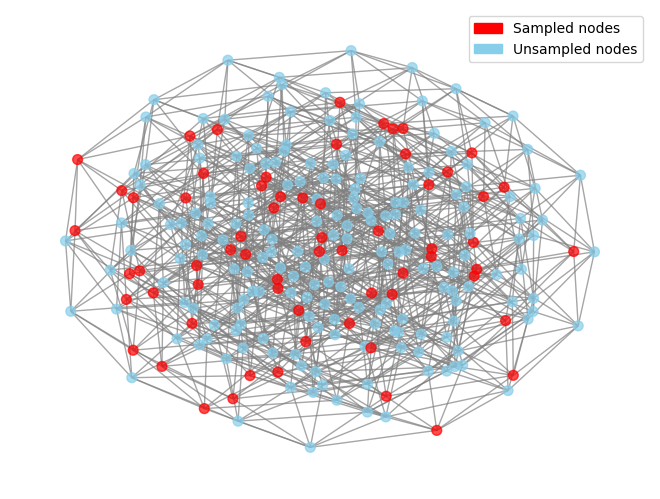

In [40]:
import matplotlib.patches as mpatches

# Map tuple nodes → integers
node_int_map = {node: int("".join(map(str, node)), 2) for node in mixer_graph.nodes()}

# Choose special nodes to highlight (integers from your sampler)
sampled_nodes = samba_gqw.sampled_states  # already integers

# Assign colors: red for special, skyblue otherwise
node_colors = [
    "red" if node_int_map[node] in sampled_nodes else "skyblue"
    for node in mixer_graph.nodes()
]

# Draw without labels
nx.draw(
    mixer_graph, pos,
    with_labels=False,
    node_color=node_colors,
    node_size=50,
    edge_color="gray", alpha=0.7
)
# Création de la légende
red_patch = mpatches.Patch(color='red', label='Sampled nodes')
blue_patch = mpatches.Patch(color='skyblue', label='Unsampled nodes')
plt.legend(handles=[red_patch, blue_patch])

plt.show()

### Interpolation of $\Gamma$

We construct the time-dependent hopping rate.

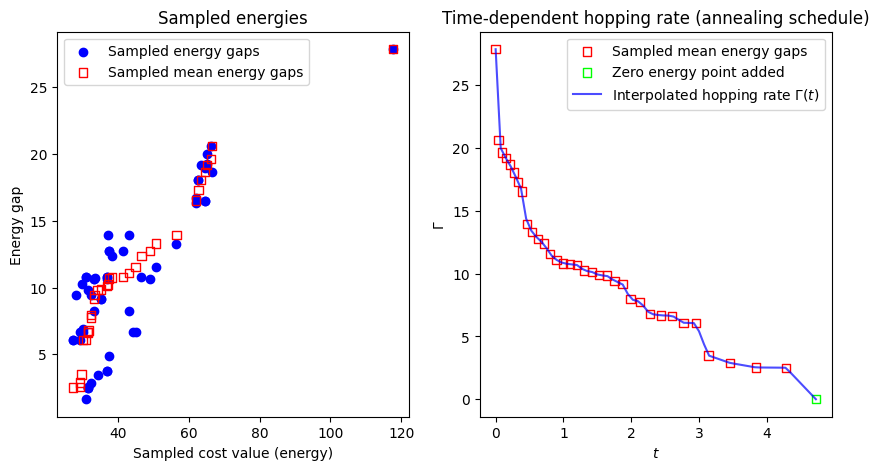

In [41]:
# Interpolation
samba_gqw.interpolate(dt=n**2)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# --- First plot ---
x_values = [val[0] for val in samba_gqw.sample.values()]
y_values = [val[1]/samba_gqw.local_mixer_gap for val in samba_gqw.sample.values()]

x_temp = samba_gqw.energies.copy()
new_temp = samba_gqw.np.concatenate([samba_gqw.np.array([samba_gqw.energies[0]]), x_temp])

# Scatter des cercles bleus (points "Sampled energy gaps")
axes[0].scatter(x_values, y_values, color='blue', label='Sampled energy gaps')

# Scatter des carrés rouges (hollow)
axes[0].scatter(samba_gqw.energies, samba_gqw.mean_gaps[::-1][1:], marker='s', facecolors='none', edgecolors='red', label="Sampled mean energy gaps")

axes[0].set_xlabel('Sampled cost value (energy)')
axes[0].set_ylabel('Energy gap')
axes[0].set_title('Sampled energies')
axes[0].legend()

# --- Second plot ---
# Scatter all points except last with hollow red squares
axes[1].scatter(samba_gqw.gap_dt[:-1], samba_gqw.mean_gaps[:-1], marker='s', facecolors='none', edgecolors='red', label='Sampled mean energy gaps')

# Scatter the last point in green (hollow)
axes[1].scatter(samba_gqw.gap_dt[-1:], samba_gqw.mean_gaps[-1:], marker='s', facecolors='none', edgecolors='lime', label='Zero energy point added')

# Plot interpolated hopping
axes[1].plot(samba_gqw.t_list, samba_gqw.hopping, color='blue', linestyle='-', linewidth=1.5, alpha=0.7, label="Interpolated hopping rate $\Gamma(t)$")

axes[1].set_xlabel('$t$')
axes[1].set_ylabel('$\Gamma$')
axes[1].set_title('Time-dependent hopping rate (annealing schedule)')
axes[1].legend()

plt.show()


## SamBa GQW: quantum part
We now solve the problem using SamBa GQW with the Hamiltonian evolution (continuous version).

### Hamiltonian evolution

In [42]:
# We perform the Hamiltonian evolution
results = samba_gqw.evolve()

# We extract the results
if samba_gqw.use_qutip:
    results_array = np.array([state.full() for state in results.states]) # array of quantum states
    times = results.times # values of evaluated time
else:
    results_array = np.array([state.to_numpy() for state in results.states]) # array of quantum states
    times = results.tsave # values of evaluated time

#### Results visualization

We compute several metrics for analysis purposes.

In [43]:
from performance_metrics import *

rank_dict = rank_solutions_by_quality(cost_quality_dict)
prob_over_time = [(np.abs(state)**2).reshape(-1) for state in results_array]
distribution_quality_over_time = [distribution_quality(pr,list(cost_quality_dict.values())) for pr in prob_over_time]
probabilities_per_rank_over_time = [[np.sum(pr[rank_dict[r]]) for pr in prob_over_time] for r in list(rank_dict.keys())]
patricipation_ratio_over_time = 1 / (2**n * np.sum(np.vstack(prob_over_time)**2, axis=1))

We first plot the several metrics over time.

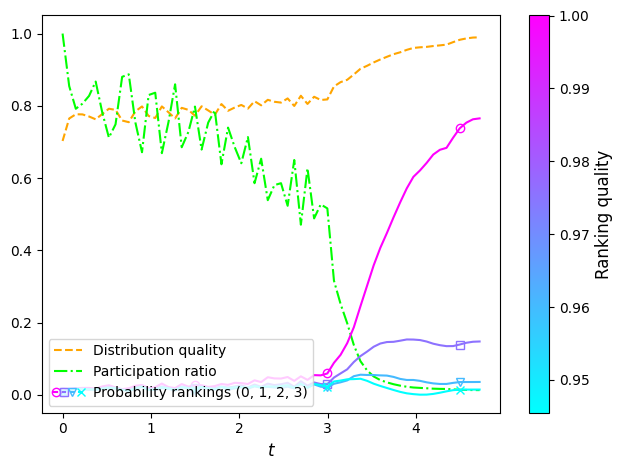

In [44]:
# We select the rankings for which we want to display the measurement probabilities over time
rank_to_display = [0,1,2,3]

# We plot several metrics over time
plot_performance(
    distribution_quality_over_time,
    patricipation_ratio_over_time,
    probabilities_per_rank_over_time,
    times,
    [cost_quality_dict[rank_dict[i][0]] for i in list(rank_dict.keys())],
    rank_list=rank_to_display,
    rank_dict=rank_dict,
    pourcentage=0,
    marker_list=None,
    markevery=20,
    markersize=6,
    show_colorbar=True,
    show_legend=True
)

We then plot the initial and final ranking distributions.

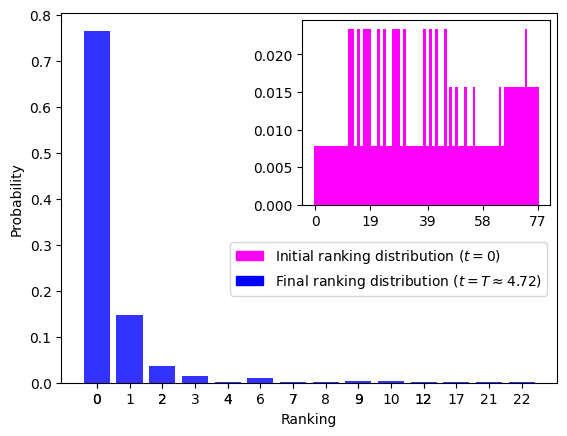

In [45]:
prob_per_rank_init = np.array([probabilities_per_rank_over_time[r][0] for r in list(rank_dict.keys())])
prob_per_rank_final = np.array([probabilities_per_rank_over_time[r][-1] for r in list(rank_dict.keys())])

plot_ranking_distribution(prob_per_rank_final=prob_per_rank_final,
                        prob_per_rank_init=prob_per_rank_init,
                        threshold=1e-3,
                        num_ticks=20,
                        inset_plot_size=50,
                        inset_plot_label='Initial ranking distribution ($t=0$)',
                        main_plot_label=rf'Final ranking distribution ($t=T\approx {round(times[-1],2)}$)',
                        save=False,
                        figname='ranking_distribution.png')

We simulate measurements in the computational basis and we select the best found approximation to be the **measured** state with lowest cost.

The best found assignment is x=198 (11000110) of ranking r=0


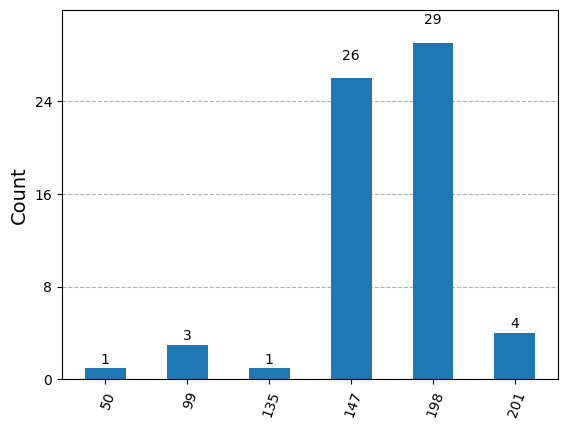

In [46]:
from collections import Counter
from qiskit.visualization import plot_histogram

def sample_measurements(probabilities, k, seed=None):
    """
    Simulate k measurements from a probability distribution.
    
    Args:
        probabilities (array-like): probability vector that sums to 1
        k (int): number of measurements
        seed (int, optional): random seed for reproducibility
    
    Returns:
        dict: {index: count of times measured}
    """
    rng = np.random.default_rng(seed)
    n = len(probabilities)
    outcomes = rng.choice(np.arange(n), size=k, p=probabilities)
    counts = dict(Counter(outcomes))
    return counts

# Number of measurements
n_shots = n**2

# Simulate the measurements
res = sample_measurements(prob_over_time[-1], n_shots, seed=42)

# Print the best found assignment
best_found_assigment = min(res.keys(), key=lambda b: cost_tsp(int_to_bitstring(b,n),adj_matrix,lam,gamma,mu))
print(f"The best found assignment is x={best_found_assigment} "
      f"({format(best_found_assigment, f'0{n}b')}) "
      f"of ranking r={next((key for key, values in rank_dict.items() if best_found_assigment in values))}")

# Plot the results of the measurements
plot_histogram(res)

We plot the best found assignement on the original graph (describing the map).

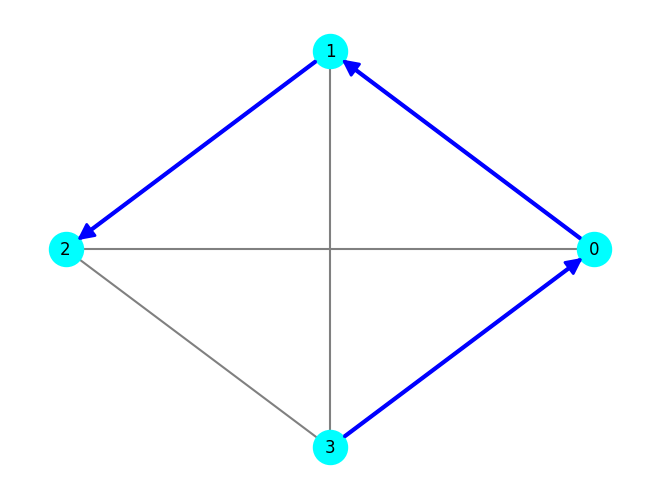

In [47]:
# We first decode the TSP encoding to get a list of vertice indices in their order of visit
path = decode_path(int_to_bitstring(best_found_assigment,n),n_cities)

# Translates the path to tuples of vertices
path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]

# Layout
pos = nx.circular_layout(g)

# Draw base graph
nx.draw(g, pos, with_labels=True, node_color='aqua', edge_color='gray', node_size=600, width=1.5)

# Draw path edges in blue
nx.draw_networkx_edges(g, pos, edgelist=path_edges, edge_color='blue', width=3)

# Manual arrows
ax = plt.gca()
node_radius = 0.065  # approx half the node's visual radius
headroom = 0.051    # small offset to prevent head from overshooting

for u, v in path_edges:
    if g.has_edge(u, v) or g.has_edge(v, u):
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        dx, dy = x2 - x1, y2 - y1
        dist = np.hypot(dx, dy)
        if dist == 0:
            continue

        # Offset the arrow slightly at both ends
        x1_offset = x1 + (node_radius / dist) * dx
        y1_offset = y1 + (node_radius / dist) * dy
        x2_offset = x2 - (headroom / dist) * dx
        y2_offset = y2 - (headroom / dist) * dy

        ax.annotate(
            '',
            xy=(x2_offset, y2_offset), xytext=(x1_offset, y1_offset),
            arrowprops=dict(
                arrowstyle='-|>',
                color='blue',
                lw=2,
                mutation_scale=25
            ),
        )

plt.axis('off')
plt.show()
